<a href="https://colab.research.google.com/github/lordzlasher/summarization-nlp/blob/main/Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
!pip install datasets
!pip install contractions
!pip install transformers
!pip install rouge

In [54]:
from datasets import load_dataset
import pandas as pd
import numpy as np 
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing
## for bart
import transformers
## for evaluation
import rouge 
import difflib
## for textrank
import gensim  
## for W2V and textRank
import gensim.downloader as gensim_api

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Dataset


In [3]:
datasets = load_dataset('cnn_dailymail', '3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
lst_dics = [dic for dic in datasets["train"]]
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text","highlights":"y"})[["text","y"]].head(20000)
dtf.head()

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [5]:
i = 1
print("--- Full text ---")
print(dtf["text"][i])
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

# Text processing


In [6]:
lst_stopwords = nltk.corpus.stopwords.words('english')
lst_stopwords_ext = ["cnn","say","said","new","wa","ha"]
lst_stopwords.extend(lst_stopwords_ext)

In [7]:
def utils_preprocess_text(txt, lst_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt

In [8]:
def add_preprocessed_text(data, column, lst_regex=None, punkt=False, lower=False, slang=False, lst_stopwords=None, stemm=False, lemm=False, remove_na=True):
    dtf = data.copy()

    ## apply preprocess
    dtf = dtf[ pd.notnull(dtf[column]) ]
    dtf[column+"_clean"] = dtf[column].apply(lambda x: utils_preprocess_text(x, lst_regex, punkt, lower, slang, lst_stopwords, stemm, lemm))
    
    ## residuals
    dtf["check"] = dtf[column+"_clean"].apply(lambda x: len(x))
    if dtf["check"].min() == 0:
        print("--- found NAs ---")
        print(dtf[[column,column+"_clean"]][dtf["check"]==0].head())
        if remove_na is True:
            dtf = dtf[dtf["check"]>0] 
            
    return dtf.drop("check", axis=1)

In [9]:
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

In [10]:
def add_text_length(data, column):
    dtf = data.copy()
    dtf['word_count'] = dtf[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(nltk.sent_tokenize(str(x))) )
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [11]:
def plot_distributions(dtf, x, max_cat=20, top=None, y=None, bins=None, figsize=(10,5)):
    ## univariate
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        ### categorical
        if dtf[x].nunique() <= max_cat:
            if top is None:
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            else:   
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            ax.set(ylabel=None)
        ### numerical
        else:
            sns.distplot(dtf[x], hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
            ax.grid(True)
            ax.set(xlabel=None, yticklabels=[], yticks=[])

    ## bivariate
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in dtf[y].unique():
            sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(dtf[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()

In [12]:
dtf = add_preprocessed_text(dtf, column="text", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
dtf = add_preprocessed_text(dtf, column="y", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
dtf.head()

,text,y,text_clean,y_clean
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,london england reuters harry potter star danie...,harry potter star daniel radcliffe get 20m for...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,editor note behind scene series correspondent ...,mentally ill inmate miami housed forgotten flo...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",minneapolis minnesota driver minneapolis bridg...,thought going die driver man pickup truck fold...
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",washington doctor removed five small polyp pre...,five small polyp found procedure none worrisom...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",national football league indefinitely suspende...,nfl chief atlanta falcon owner critical michae...


In [13]:
# check
print("--- Full text ---")
print(dtf["text_clean"][i])
print(" ")
print("--- Summary ---")
print(dtf["y_clean"][i])

--- Full text ---
editor note behind scene series correspondent share experience covering news analyze story behind event soledad obrien take user inside jail many inmate mentally ill inmate housed forgotten floor many mentally ill inmate housed miami trial miami florida ninth floor miamidade pretrial detention facility dubbed forgotten floor inmate severe mental illness incarcerated ready appear court often face drug charge charge assaulting officer charge judge steven leifman usually avoidable felony arrest often result confrontation police mentally ill people often told police arrive scene confrontation seems exacerbate illness become paranoid delusional le likely follow direction according leifman end ninth floor severely mentally disturbed getting real help jail toured jail leifman well known miami advocate justice mentally ill even though exactly welcomed open arm guard given permission shoot videotape tour floor go inside forgotten floor first hard determine people prisoner wear

<ipython-input-9-2a053c0948d8>:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))


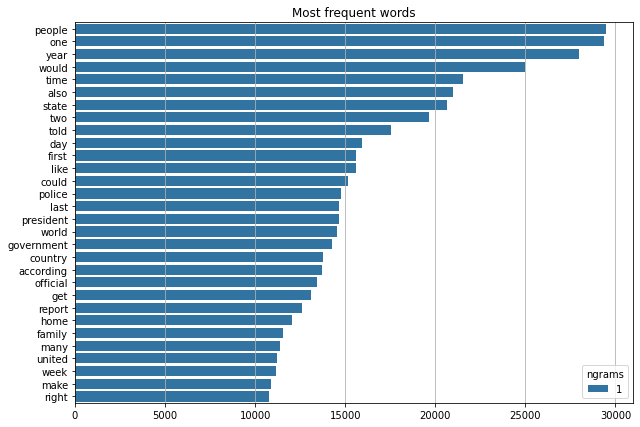

In [14]:
# Find most common words in text
dtf_freq = word_freq(corpus=dtf["text_clean"], ngrams=[1], top=30, figsize=(10,7))

In [15]:
thres = 5
X_top_words = len(dtf_freq[dtf_freq["freq"]>thres])
X_top_words

41277

<ipython-input-9-2a053c0948d8>:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))


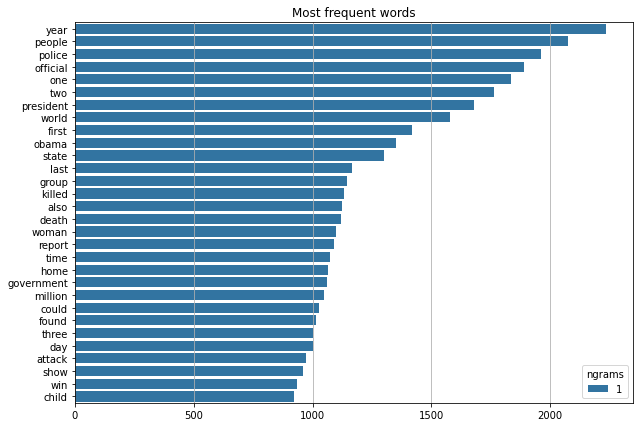

In [16]:
# Find most common words in summaries
dtf_freq = word_freq(corpus=dtf["y_clean"], ngrams=[1], top=30, figsize=(10,7))

In [17]:
thres = 5
y_top_words = len(dtf_freq[dtf_freq["freq"]>thres])
y_top_words

10121

In [18]:
# Texts
X = add_text_length(dtf, "text_clean")

                          min        mean          max
char_count           64.00000  2045.42595  7562.000000
word_count           11.00000   330.38190  1309.000000
sentence_count        1.00000     1.00000     1.000000
avg_word_length       4.62704     6.20351     7.666667
avg_sentence_lenght  11.00000   330.38190  1309.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


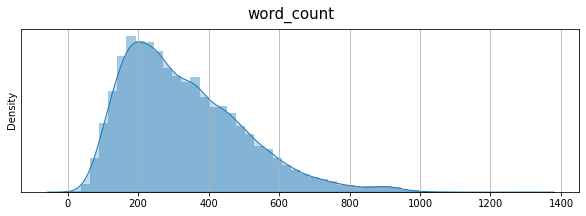

In [19]:
plot_distributions(X, x="word_count", figsize=(10,3))

In [20]:
X_len = 400

In [21]:
# Summaries
y = add_text_length(dtf, "y_clean")

                           min        mean         max
char_count           35.000000  164.948200  324.000000
word_count            6.000000   27.180400   53.000000
sentence_count        1.000000    1.000000    1.000000
avg_word_length       3.785714    6.097504    9.043478
avg_sentence_lenght   6.000000   27.180400   53.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


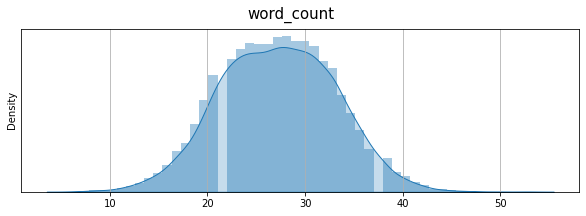

In [22]:
plot_distributions(y, x="word_count", max_cat=1, figsize=(10,3))

In [23]:
y_len = 60

In [24]:
#data train & data test
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]

# Model BART

In [25]:
def bart(corpus, max_len):    
    nlp = transformers.pipeline("summarization")    
    lst_summaries = [nlp(txt,               
                         max_length=max_len
                         )[0]["summary_text"].replace(" .", ".")                    
                     for txt in corpus]    
    return lst_summaries

In [26]:
def evaluate_summary(y_test, predicted):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, predicted, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_2, 
          "--> avg rouge:", round(np.mean([score_1,score_2,score_L]), 2))

In [27]:
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [28]:
def utils_split_sentences(a, b):
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b


In [32]:
# Test (no Train)
predicted = bart(corpus=dtf_test["text"], max_len=y_len)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [38]:
# Evaluate
evaluate_summary(dtf_test["y"][i], predicted[i])

rouge1: 0.38 | rouge2: 0.16 | rougeL: 0.16 --> avg rouge: 0.26


In [39]:
# Compare y_test and predicted
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, 
                                titles=["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

In [40]:
# Explainability
match = display_string_matching(dtf_test["text"][i], predicted[i], both=True, sentences=True,titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

# Model Seq2Seq

**Features Engineering**

In [41]:
def text2seq(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], fitted_tokenizer=None, top=None, oov=None, maxlen=None, padding="<PAD>"):    
    print("--- tokenization ---")
    
    ## detect common n-grams in corpus
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)

    ## bow with keras to get text2tokens without creating the sparse matrix
    ### train
    if fitted_tokenizer is None:
        tokenizer = kprocessing.text.Tokenizer(num_words=top, lower=False, split=' ', char_level=False, oov_token=oov,
                                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
        tokenizer.fit_on_texts(lst_corpus)
        dic_vocabulary = {padding:0}
        words = tokenizer.word_index if top is None else dict(list(tokenizer.word_index.items())[0:top+1])
        dic_vocabulary.update(words)
        print(len(dic_vocabulary), "words")
    else:
        tokenizer = fitted_tokenizer
    ### transform
    lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

    ## padding sequence (from [1,2],[3,4,5,6] to [0,0,1,2],[3,4,5,6])
    print("--- padding to sequence ---")
    X = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=maxlen, padding="post", truncating="post")
    print(X.shape[0], "sequences of length", X.shape[1]) 

    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
    plt.show()
    return {"X":X, "tokenizer":tokenizer, "dic_vocabulary":dic_vocabulary} if fitted_tokenizer is None else X

In [42]:
def utils_preprocess_ngrams(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[]):
    ## create list of n-grams
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [grams_join.join(lst_words[i:i + ngrams]) for i in range(0, len(lst_words), ngrams)]
        lst_corpus.append(lst_grams)
    
    ## detect common bi-grams and tri-grams
    if len(lst_ngrams_detectors) != 0:
        for detector in lst_ngrams_detectors:
            lst_corpus = list(detector[lst_corpus])
    return lst_corpus

In [43]:
def vocabulary_embeddings(dic_vocabulary, nlp=None):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
    for word,idx in dic_vocabulary.items():
        ## update the row with vector
        try:
            embeddings[idx] =  nlp[word]
        ## if word not in model then skip and the row stays all zeros
        except:
            pass
    print("vocabulary mapped to", embeddings.shape[0], "vectors of size", embeddings.shape[1])
    return embeddings

In [63]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

--- tokenization ---
41279 words
--- padding to sequence ---
19998 sequences of length 400


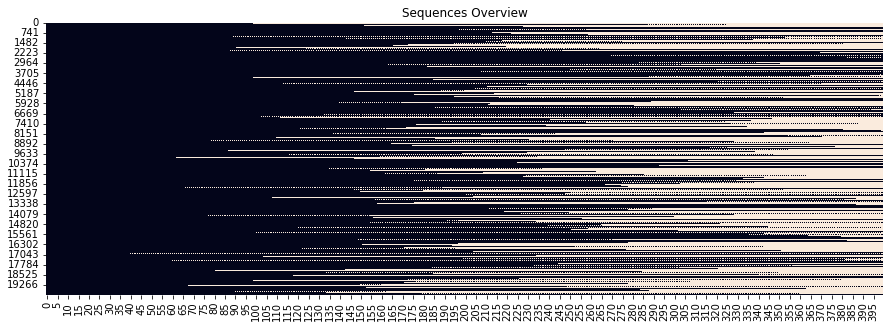

In [44]:
# Create X_train for seq2seq (sequences of tokens)
dic_seq = text2seq(corpus=dtf_train["text_clean"], top=X_top_words, maxlen=X_len)

X_train, X_tokenizer, X_dic_vocabulary = dic_seq["X"], dic_seq["tokenizer"], dic_seq["dic_vocabulary"]

In [45]:
dict(list(X_dic_vocabulary.items())[0:6])

{'<PAD>': 0, 'people': 1, 'one': 2, 'year': 3, 'would': 4, 'time': 5}

--- tokenization ---
--- padding to sequence ---
2 sequences of length 400


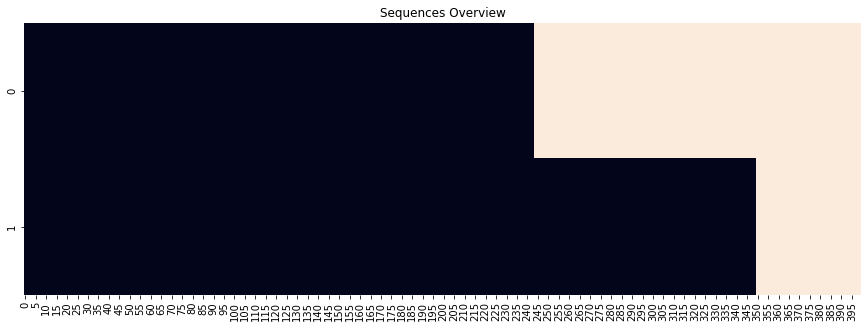

In [46]:
# Preprocess X_test with the same tokenizer
X_test = text2seq(corpus=dtf_test["text_clean"], fitted_tokenizer=X_tokenizer, maxlen=X_train.shape[1])

In [47]:
# Add START and END tokens to the summaries (y)
special_tokens = ("", "")
dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
dtf_test["y_clean"][i]

<ipython-input-47-c0f281217a54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
<ipython-input-47-c0f281217a54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])


' mentally ill inmate miami housed forgotten floor judge steven leifman result avoidable felony tour facility patient shout son president leifman system unjust fighting change '

--- tokenization ---
10123 words
--- padding to sequence ---
19998 sequences of length 60


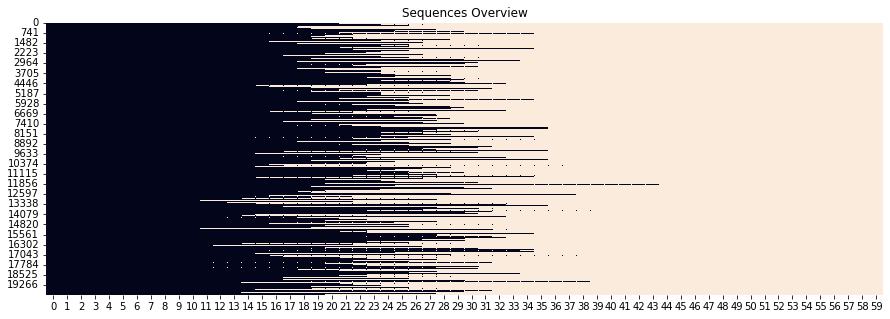

In [48]:
# Tokenize the summaries (y_train)
dic_seq = text2seq(corpus=dtf_train["y_clean"], top=y_top_words, maxlen=y_len)

y_train, y_tokenizer, y_dic_vocabulary = dic_seq["X"], dic_seq["tokenizer"], dic_seq["dic_vocabulary"]

In [49]:
dict(list(y_dic_vocabulary.items())[0:6])

{'<PAD>': 0, 'year': 1, 'people': 2, 'police': 3, 'official': 4, 'one': 5}

--- tokenization ---
--- padding to sequence ---
2 sequences of length 60


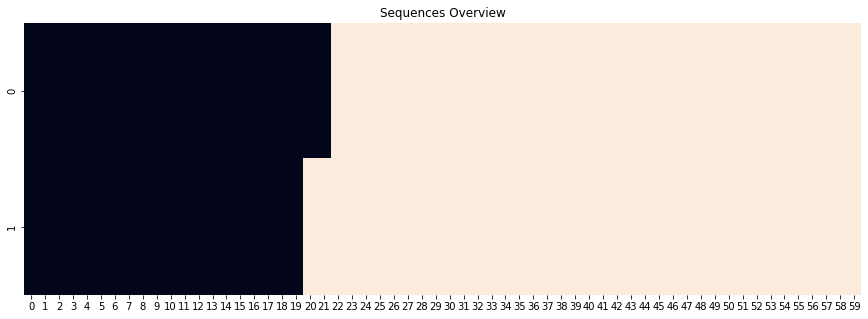

In [50]:
# Preprocess y_test with the same tokenizer
y_test = text2seq(corpus=dtf_test["y_clean"], fitted_tokenizer=y_tokenizer, maxlen=y_train.shape[1])

In [55]:
# Load pre-trained Word2Vec
nlp = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [56]:
# check nlp model
word = "home"
nlp[word].shape

(300,)

In [57]:
X_embeddings = vocabulary_embeddings(X_dic_vocabulary, nlp)
X_embeddings.shape

vocabulary mapped to 41280 vectors of size 300


(41280, 300)

In [58]:
y_embeddings = vocabulary_embeddings(y_dic_vocabulary, nlp)
y_embeddings.shape

vocabulary mapped to 10124 vectors of size 300


(10124, 300)

**Models**

In [59]:
# Basic Seq2Seq
lstm_units = 250
embeddings_size = 300

##------------ ENCODER (embeddings + lstm) -----------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", input_dim=len(X_dic_vocabulary), output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, dropout=0.4,  
                           return_sequences=True, return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)

##------------ DECODER (embeddings + lstm + dense) ---------------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", input_dim=len(y_dic_vocabulary), output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, dropout=0.4,
                           return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", 
                                     layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

##---------------------------- COMPILE --------------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 400)]        0           []                               
                                                                                                  
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 400, 300)     12383700    ['x_in[0][0]']                   
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    3036900     ['y_in[0][0]']                   
                                                                                            

In [60]:
# Advanced Seq2Seq
lstm_units = 250

##------------ ENCODER (pre-trained embeddings + 3 bi-lstm) ---------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", input_dim=X_embeddings.shape[0], output_dim=X_embeddings.shape[1], 
                               weights=[X_embeddings], trainable=False)
x_emb = layer_x_emb(x_in)
### bi-lstm 1
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4,
                                                  return_sequences=True, return_state=True), 
                                      name="x_lstm_1")
x_out, _, _, _, _ = layer_x_bilstm(x_emb)
### bi-lstm 2
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4,
                                                  return_sequences=True, return_state=True),
                                      name="x_lstm_2")
x_out, _, _, _, _ = layer_x_bilstm(x_out)
### bi-lstm 3 (here final states are collected)
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4, 
                                                  return_sequences=True, return_state=True),
                                      name="x_lstm_3")
x_out, forward_h, forward_c, backward_h, backward_c = layer_x_bilstm(x_out)
state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

##------------ DECODER (pre-trained embeddings + lstm + dense) ------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", input_dim=y_embeddings.shape[0], output_dim=y_embeddings.shape[1], 
                               weights=[y_embeddings], trainable=False)
y_emb = layer_y_emb(y_in)
### lstm
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units*2, dropout=0.2, recurrent_dropout=0.2,
                           return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", 
                                     layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

##---------------------------- COMPILE ------------------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 400)]        0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 400, 300)     12384000    ['x_in[0][0]']                   
                                                                                                  
 x_lstm_1 (Bidirectional)       [(None, 400, 500),   1102000     ['x_emb[0][0]']                  
                                 (None, 250),                                                     
                                 (None, 250),                                                     
                                 (None, 250),                                               

In [61]:
def fit_seq2seq(X_train, y_train, model=None, X_embeddings=None, y_embeddings=None, build_encoder_decoder=True, epochs=100, batch_size=64, verbose=1):    
    ## model
    if model is None:
        ### params
        len_vocabulary_X, embeddings_dim_X = X_embeddings.shape
        len_vocabulary_y, embeddings_dim_y = y_embeddings.shape
        lstm_units = 250
        max_seq_lenght = X_train.shape[1]
        ### encoder (embedding + lstm)
        x_in = layers.Input(name="x_in", shape=(max_seq_lenght,))
        layer_x_emb = layers.Embedding(name="x_emb", input_dim=len_vocabulary_X, output_dim=embeddings_dim_X, 
                                       weights=[X_embeddings], trainable=False)
        x_emb = layer_x_emb(x_in)
        layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, return_sequences=True, return_state=True)
        x_out, state_h, state_c = layer_x_lstm(x_emb)
        ### decoder (embedding + lstm + dense)
        y_in = layers.Input(name="y_in", shape=(None,))
        layer_y_emb = layers.Embedding(name="y_emb", input_dim=len_vocabulary_y, output_dim=embeddings_dim_y, 
                                       weights=[y_embeddings], trainable=False)
        y_emb = layer_y_emb(y_in)
        layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, return_sequences=True, return_state=True)
        y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
        layer_dense = layers.TimeDistributed(name="dense", 
                                             layer=layers.Dense(units=len_vocabulary_y, activation='softmax'))
        y_out = layer_dense(y_out)
        ### compile
        model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
        model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        print(model.summary())
        
    ## train
    training = model.fit(x=[X_train, y_train[:,:-1]], 
                         y=y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                         batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3,
                         callbacks=[callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)])
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## build prediction enconder-decoder model
    if build_encoder_decoder is True:
        lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
        ### encoder
        encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
        ### decoder
        encoder_out = layers.Input(shape=(max_seq_lenght, lstm_units))
        state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
        y_emb2 = layer_y_emb(y_in)
        y_out2, new_state_h, new_state_c = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
        predicted_prob = layer_dense(y_out2) 
        decoder_model = models.Model(inputs=[y_in, encoder_out, state_h, state_c], 
                                     outputs=[predicted_prob, new_state_h, new_state_c], 
                                     name="Prediction_Decoder")
        return training.model, encoder_model, decoder_model
    else:
        return training.model


In [ ]:
model = fit_seq2seq(X_train, y_train, model, build_encoder_decoder=False, 
                    epochs=100, batch_size=64, verbose=1)

Epoch 1/100
 91/219 [===========>..................] - ETA: 21:12 - loss: 3.1107